In [1]:
%load_ext autoreload
%autoreload 2

# Introduction

Most dynamic equilbrium models in economics do not have closed form solutions.  Instead, numerical methods are used to approximate their behavior. Here I show how Deep-Q Learning with a Natural Advantage Function can be used to approximate the solution to dynamic equilibrium models.

First, I review the neoclassical growth model.  Then I show how to solve the model using the Value Iteration Approach.  Finally, I show how to solve the model using Deep-Q Learning with the Natural Advantage Function.  In the future, I'll compare the accuracy of the Deep-Q Learning to Peturbation Methods and the Value Iteration Approach on more complicated models.

Useful background material is "Comparing Solution Methods for Dynamic Equilibrium Economies" (https://www.econstor.eu/bitstream/10419/100716/1/wp2003-27.pdf) which describes the relative accuracy existing numerical solution methods.  "Continuous Deep Q-Learning with Model-based Acceleration" (https://arxiv.org/pdf/1603.00748.pdf) introduces the Natural Advantage function.

## The Neoclassical Model

The neoclassical growth model was introduced in the 40s to describe long-term growth of economies. It involves a planner for the economy.  The planner faces a bread vs butter problem. She has some capital today.  She needs to decide how much capital society should consume today vs how much capital she should invest so people can consume tomorrow.

The two building blocks are the utility function: how happy society is from consuming $c_t$.  And the production function, how much can society produce given capital $k_t$section

Given capital $k_t$ in period $t$, society can produce $z_tk_t^{\alpha}$ capital the next period.  Where $\alpha < 1$, there are diminishing returns. And there is a technology $z_t>0$.  Capital deprecates at rate $\delta$. Therefore the production function looks like

$$z_tk_t^{\alpha} + (1- \delta)k_t$$

The utility function is the $\log$ of consumption, eg there are diminishing returns to consuming.  In more complicated models there would also be leisure and a return on leisure.  Putting these building blocks together the planners problem looks like

$$ \max_{c_t, k_{t+1}} \mathbb{E} \sum_{t=0}^{\inf} (1-\beta)\beta^t \log{c_t}$$

subject to

$$c_t + k_{t+1} = z_tk_t^{\alpha} + (1- \delta)k_t$$ 

The planners problem is to choose $c_t$ and $k_{t+1}$ to maximize utility. 

What makes this an RBC problem is that we hav productivity shocks. So the $z_t$ is stochastic.

# Value Iteration Approach

Aruoba and Fernández-Villaverde solve the problem using the Value Iteration Approach here https://github.com/jesusfv/Comparison-Programming-Languages-Economics/blob/master/RBC_Python.py

The difficulty in useing the "Value Iteration Method" is that the state space and decision spaces are continious.  But value itearation is discrete.  The most straightforward approach reproduced below is to just discretize the space.  That approach is the most accurate.  But also doesn't scale computationally, the complexity increases exponentially with the complexity of the state space. 

The code is reproduced below.  First, we define the dynamics of the economy.

In [11]:
import numpy as np

aalpha = 1.0/3.0     # Elasticity of output w.r.t. capital
bbeta  = 0.95        # Discount factor

# Productivity values
vProductivity = np.array([0.9792, 0.9896, 1.0000, 1.0106, 1.0212],float)

# Transition matrix
mTransition = np.array([[0.9727, 0.0273, 0.0000, 0.0000, 0.0000],
                     [0.0041, 0.9806, 0.0153, 0.0000, 0.0000],
                     [0.0000, 0.0082, 0.9837, 0.0082, 0.0000],
                     [0.0000, 0.0000, 0.0153, 0.9806, 0.0041],
                     [0.0000, 0.0000, 0.0000, 0.0273, 0.9727]],float)

Then we reproduce the grids used to solve solve the problem.

In [8]:
capitalSteadyState     = (aalpha*bbeta)**(1/(1-aalpha))
outputSteadyState      = capitalSteadyState**aalpha
consumptionSteadyState = outputSteadyState-capitalSteadyState

# We generate the grid of capital
vGridCapital           = np.arange(0.5*capitalSteadyState,1.5*capitalSteadyState,0.00001)

nGridCapital           = len(vGridCapital)
nGridProductivity      = len(vProductivity)

## 3. Required matrices and vectors

mOutput           = np.zeros((nGridCapital,nGridProductivity),dtype=float)
mValueFunction    = np.zeros((nGridCapital,nGridProductivity),dtype=float)
mValueFunctionNew = np.zeros((nGridCapital,nGridProductivity),dtype=float)
mPolicyFunction   = np.zeros((nGridCapital,nGridProductivity),dtype=float)
expectedValueFunction = np.zeros((nGridCapital,nGridProductivity),dtype=float)

 # 4. We pre-build output for each point in the grid

for nProductivity in range(nGridProductivity):
    mOutput[:,nProductivity] = vProductivity[nProductivity]*(vGridCapital**aalpha)

print("Output = ", outputSteadyState, " Steady State Capital = ", capitalSteadyState, "  Steady State Consumption = ", consumptionSteadyState)
print("len vGridCapital", nGridCapital, "dim mPolicyFunction", mPolicyFunction.shape)


Output =  0.5627314338711378  Steady State Capital =  0.178198287392527   Steady State Consumption =  0.3845331464786108
len vGridCapital 17820 dim mPolicyFunction (17820, 5)


In [10]:
import math
import time

t1=time.time()

maxDifference = 10.0
tolerance = 0.0000001
iteration = 0

log = math.log
zeros = np.zeros
dot = np.dot

while(maxDifference > tolerance):
    expectedValueFunction = dot(mValueFunction,mTransition.T)

    for nProductivity in range(nGridProductivity):

        # We start from previous choice (monotonicity of policy function)
        gridCapitalNextPeriod = 0

        for nCapital in range(nGridCapital):

            valueHighSoFar = -100000.0
            capitalChoice  = vGridCapital[0]

            for nCapitalNextPeriod in range(gridCapitalNextPeriod,nGridCapital):
                consumption = mOutput[nCapital,nProductivity] - vGridCapital[nCapitalNextPeriod]
                valueProvisional = (1-bbeta)*log(consumption)+bbeta*expectedValueFunction[nCapitalNextPeriod,nProductivity];

                if valueProvisional>valueHighSoFar:
                    valueHighSoFar = valueProvisional
                    capitalChoice = vGridCapital[nCapitalNextPeriod]
                    gridCapitalNextPeriod = nCapitalNextPeriod
                else:
                    break # We break when we have achieved the max


            mValueFunctionNew[nCapital,nProductivity] = valueHighSoFar
            mPolicyFunction[nCapital,nProductivity]   = capitalChoice

    maxDifference = (abs(mValueFunctionNew-mValueFunction)).max()

    mValueFunction    = mValueFunctionNew
    mValueFunctionNew = zeros((nGridCapital,nGridProductivity),dtype=float)

    iteration += 1
    if(iteration%10 == 0 or iteration == 1):
        print(" Iteration = ", iteration, ", Sup Diff = ", maxDifference)
        
print(" Iteration = ", iter, ", Sup Duff = ", maxDifference)
print(" ")
print(" My Check = ", mPolicyFunction[1000-1,3-1])
print(" ")

t2 = time.time()

print("Elapse time = is ", t2-t1)

 Iteration =  1 , Sup Diff =  0.05274159340733661
 Iteration =  10 , Sup Diff =  0.031346949265852186
 Iteration =  20 , Sup Diff =  0.0187034598933572
 Iteration =  30 , Sup Diff =  0.01116551203397076
 Iteration =  40 , Sup Diff =  0.006668541708132469
 Iteration =  50 , Sup Diff =  0.003984292748717144
 Iteration =  60 , Sup Diff =  0.0023813118039327508
 Iteration =  70 , Sup Diff =  0.0014236586450981914
 Iteration =  80 , Sup Diff =  0.0008513397747206275
 Iteration =  90 , Sup Diff =  0.0005092051752288995
 Iteration =  100 , Sup Diff =  0.00030462324421465237
 Iteration =  110 , Sup Diff =  0.00018226485632311107
 Iteration =  120 , Sup Diff =  0.00010906950872624499
 Iteration =  130 , Sup Diff =  6.527643736298216e-05
 Iteration =  140 , Sup Diff =  3.907108211997912e-05
 Iteration =  150 , Sup Diff =  2.338807712021218e-05
 Iteration =  160 , Sup Diff =  1.400864463707574e-05
 Iteration =  170 , Sup Diff =  8.391317202871562e-06
 Iteration =  180 , Sup Diff =  5.026474537928

Note "My Check" compares the solution of a particular location in the grid to the closed form solution when delta=1.

# Non-grid Based Solutions

Historically economists have used "projection ethods" to solve for sparsity.  They fit the value at certain loations. They fit the value functions to Chebyshev polynomials and then solve for the coeffeients that minimize the Bellman errors.

Of course neural networks are much universal function approximaters than Chebyshev polynomials.  We should try to do that instead!

There are two papers that do so

[Deep Reinforcement Learning in Macroeconomics, Atashbar and Shi 2023](https://www.imf.org/-/media/Files/Publications/WP/2023/English/wpiea2023040-print-pdf.ashx&ved=2ahUKEwizrvS3upeNAxVIBTQIHU_HEvIQFnoECA0QAQ&usg=AOvVaw0LcQOIlCBsYHU0U4V3bUU0)

Use reinforcement learning techniques like DDPG to solve RBC models

["Solving high-dimensional dynamic stochastic models using deep learning"](https://www.nber.org/papers/w28299)

Use value iteration on the ergodic set including the Bellman Error in the loss to solve RBC models.

But I think both of these approaches are too complicated! And that plain value iteration with neural approximaters will suffice

In [15]:
import matplotlib.pyplot as plt

def q(expectedValueFunction, nCapital, nProductivity, nCapitalNextPeriod):
    """
    Compute Q(k, z, k') = u(c) + beta * E[V(k', z')]

    Parameters:
        expectedValueFunction: precomputed E[V(k', z')]
        nCapital: index of current capital
        nProductivity: index of current productivity
        nCapitalNextPeriod: index of next-period capital choice

    Returns:
        Q value for given state and action
    """
    consumption = mOutput[nCapital,nProductivity] - vGridCapital[nCapitalNextPeriod]
    return (1-bbeta)*math.log(consumption)+bbeta*expectedValueFunction[nCapitalNextPeriod,nProductivity]

def visualize_q(mValueFunction):
    """
    Plot Q(k, z, k') for a fixed (k, z), varying over k'

    Parameters:
        mValueFunction: current value function matrix
        mOutput: output matrix precomputed over (k, z)
        vGridCapital: capital grid
        mTransition: Markov transition matrix
        bbeta: discount factor
    """
    nCapital = len(vGridCapital) // 2  # Midpoint in grid
    nProductivity = mOutput.shape[1] // 2  # Midpoint z index

    # Precompute E[V(k', z')]
    expectedValueFunction = np.dot(mValueFunction, mTransition.T)

    q_vals = []
    k_prime_vals = []

    for nCapitalNextPeriod in range(len(vGridCapital)):
        c = mOutput[nCapital, nProductivity] - vGridCapital[nCapitalNextPeriod]
        if c <= 0:
            q_val = -np.inf
        else:
            q_val = q(expectedValueFunction, nCapital, nProductivity, nCapitalNextPeriod)
        q_vals.append(q_val)
        k_prime_vals.append(vGridCapital[nCapitalNextPeriod])

    plt.figure(figsize=(8, 5))
    plt.plot(k_prime_vals, q_vals)
    plt.xlabel("Next-period capital $k'$")
    plt.ylabel("Q-value")
    plt.title(f"Q(k={vGridCapital[nCapital]:.3f}, z_index={nProductivity}) vs $k'$")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


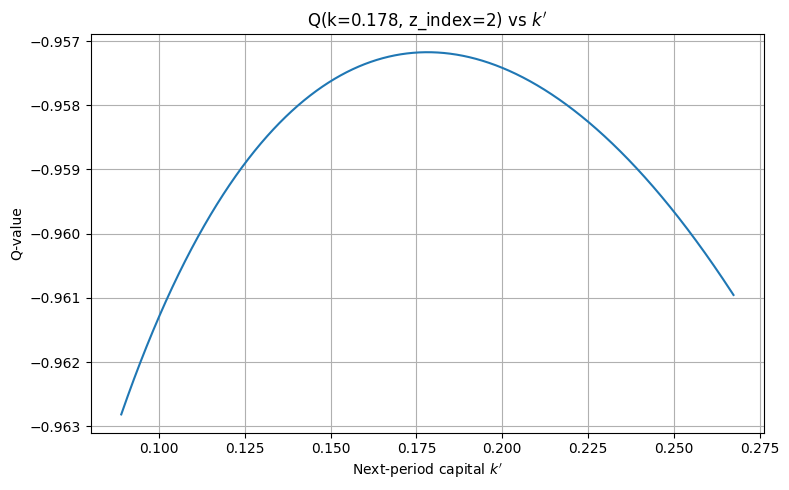

In [16]:
visualize_q(mValueFunction)

From the above we see in our example at least that the Q function is very smooth. 

(1) Compared to RL problems like Cartpole sampling states near the optimal policy is probably not very important. The policy far from the optimal is likely to generalize well to the streategy near the optimal.

(2) The value function is very flat.  While in cartpole if you make a mistake you fall off a cliff.  In RBC models you just have a small deviation from the optimum.  So the solution is likely to be thrown off if the value function is badly specified.

Another thing that is different than Cartpole is that its easy to guess if the solution is pretty good

(1) We can visualize how well the solution does when delta=1 and we have a closed form solution
(2) We can check if the Euler conditions are met

In [26]:
import train_neuralgrid

model = train_neuralgrid.main(cold_start=False, uniform_sampling=True)

Step 250 completed, value_loss 0.005875627510249615 action_loss 2.1829426288604736 value error 0.18020643293857574 euler error 0.15052133060394648
Step 500 completed, value_loss 0.00947955809533596 action_loss 3.9330270290374756 value error 0.13411416113376617 euler error 0.010829059091736178
Training is complete


<module 'matplotlib.pyplot' from '/home/ygreif/code/bellmansrevenge/venv/lib/python3.10/site-packages/matplotlib/pyplot.py'>

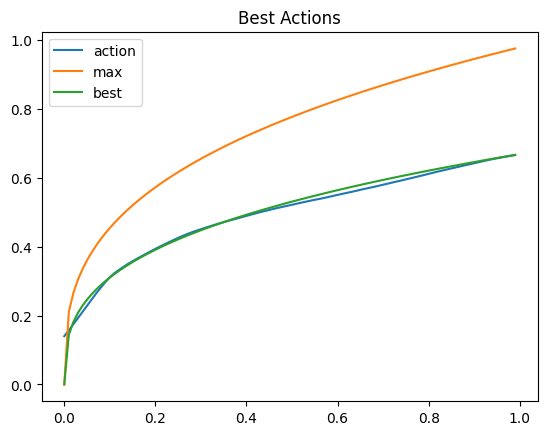

In [34]:
from qtable.q_utils import render_v_vs_target, renderBestA, renderV

renderBestA(model)
    

In reality it took some debugging.  But that was really easy!  Doing the straightforward thing yieled a Eueler error of 1% and a strategy that visually looks optimal.

Training actions coldstart
0 0.33864763379096985
[0] predicted mean: 1.0084, target mean: 0.4287, loss: 0.3386
25 0.017634140327572823
[25] predicted mean: 0.5059, target mean: 0.4265, loss: 0.0176
50 0.004867228679358959
[50] predicted mean: 0.4450, target mean: 0.4281, loss: 0.0049
75 0.0007373327389359474
[75] predicted mean: 0.4377, target mean: 0.4297, loss: 0.0007


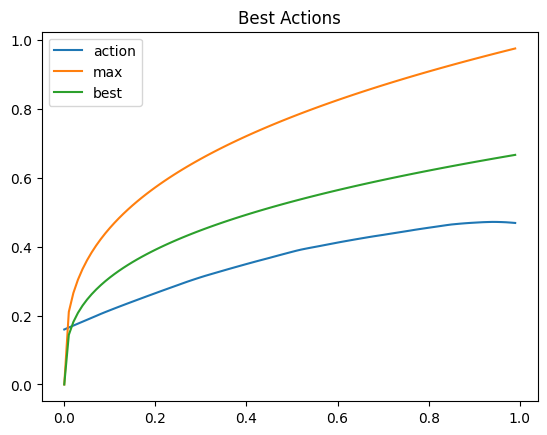

[Critic Pretraining Step 0] value loss = 0.797225
[Critic Pretraining Step 1] value loss = 0.791320


KeyboardInterrupt: 

In [70]:
params = {'batch_size': 256,
          'hidden_sizes': [256, 256],
          'lr':1e-3,
          'tau':.001,
          'beta':.95,
          'coldstart_critic': True}

import train_rl
model = train_rl.run(**params)

In [75]:
from policy import diagnostics
from envs.economy import jesusfv
print(diagnostics.euler_error(model, jesusfv, 30, {'k': .1, 'z': 0}, debug=True))

iter 0 eps -0.04128744894493304 k 0.1 z 0
iter 1 eps -0.09642138165017648 k 0.15278590515291507 z 0
iter 2 eps -0.12042661752450344 k 0.18420090218002372 z 0
iter 3 eps -0.12716711171768685 k 0.19986009680481065 z 0
iter 4 eps -0.12894860624309007 k 0.2064883799398053 z 0
iter 5 eps -0.12951498369801445 k 0.20905263193673285 z 0
iter 6 eps -0.1297171749908537 k 0.2100136548679421 z 0
iter 7 eps -0.12978908971234615 k 0.2103704910832347 z 0
iter 8 eps -0.12981588402218872 k 0.21050224668645146 z 0
iter 9 eps -0.12982558225841953 k 0.21055090498880735 z 0
iter 10 eps -0.12982918119315187 k 0.21056884192963388 z 0
iter 11 eps -0.12983058609960377 k 0.2105754297039092 z 0
iter 12 eps -0.12983093013064165 k 0.2105778689414799 z 0
iter 13 eps -0.12983076011837 k 0.21057874742128369 z 0
iter 14 eps -0.12983112481402165 k 0.21057902108111848 z 0
iter 15 eps -0.12983114666266662 k 0.21057915423036355 z 0
iter 16 eps -0.1298309886181126 k 0.21057921741073327 z 0
iter 17 eps -0.12983098520837136 

Training actions coldstart
0 0.33478638529777527
[0] predicted mean: 1.0028, target mean: 0.4275, loss: 0.3348
25 0.01680338941514492
[25] predicted mean: 0.5026, target mean: 0.4281, loss: 0.0168
50 0.004574304446578026
[50] predicted mean: 0.4441, target mean: 0.4262, loss: 0.0046
75 0.0005849479930475354
[75] predicted mean: 0.4385, target mean: 0.4340, loss: 0.0006


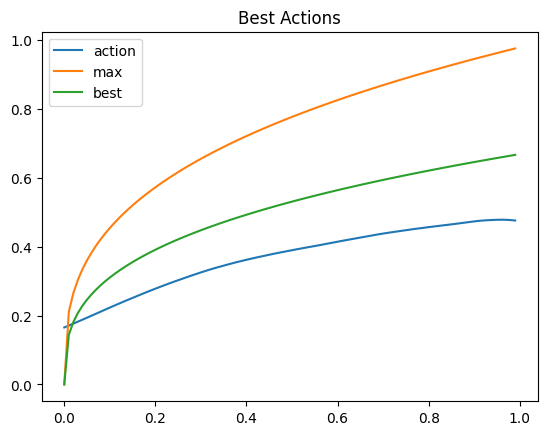

[Critic Pretraining Step 0] value loss = 0.756145
[Critic Pretraining Step 1] value loss = 0.747528
Before training, but after coldstart


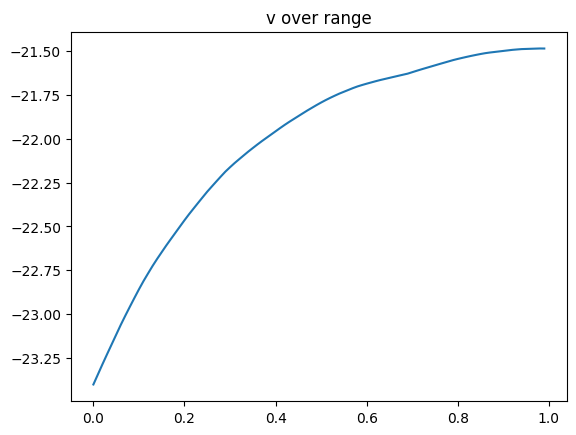

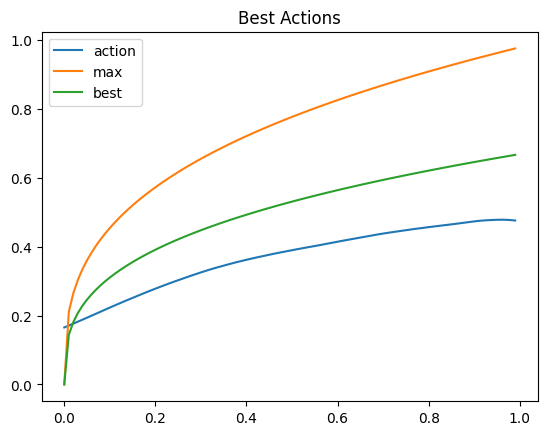

Step 0 utility -26.792638650744287
Episode 0 utility -26.792638650744287 convergence 8.706066267905044e-08 completed value error 0.04776795208454132 euler error 0.3721359547463972


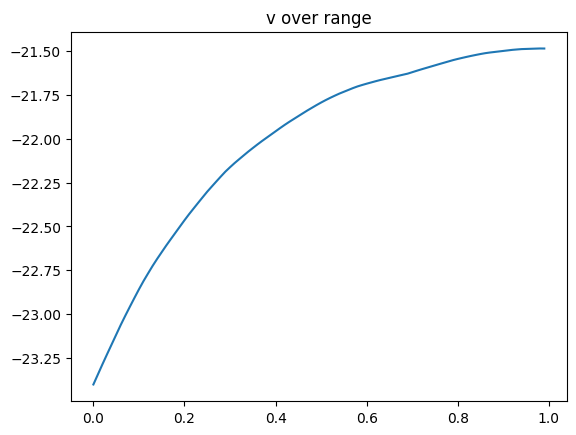

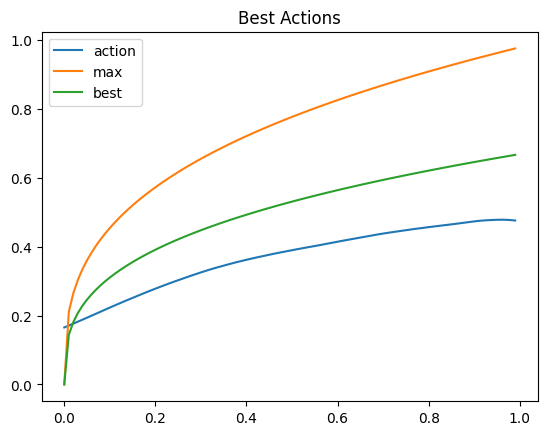

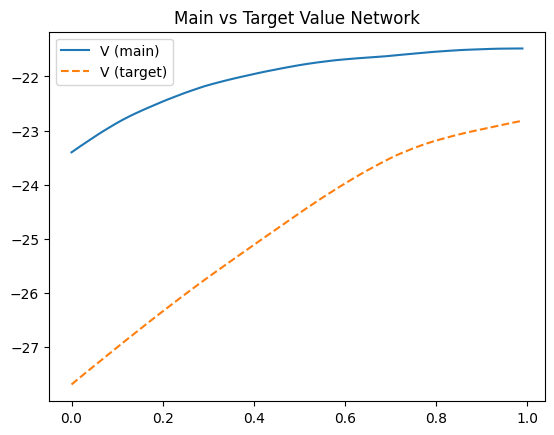

Step 10 utility -27.627008502832723
Step 20 utility -26.652950219849842
Step 30 utility -23.46878274446511
Step 40 utility -24.28793626936422
Step 50 utility -24.156611678771355
Episode 50 utility -24.156611678771355 convergence 0.012926437892019749 completed value error 0.049515098333358765 euler error 143.01683870503408


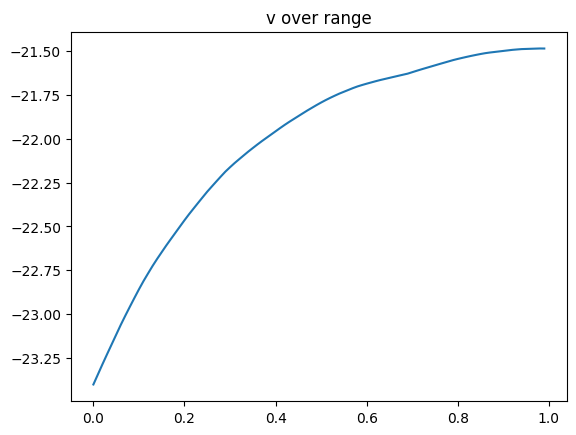

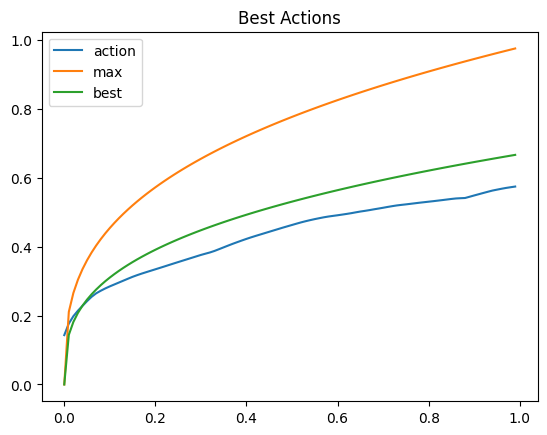

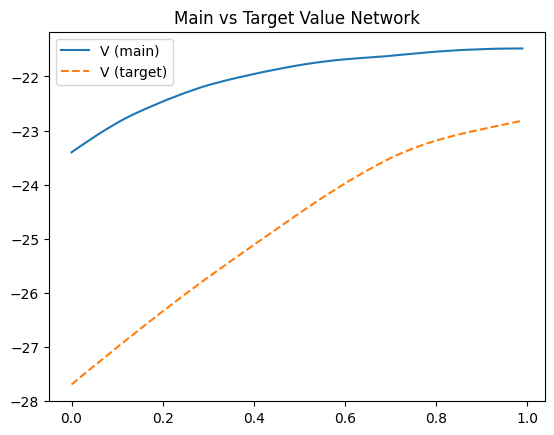

Step 60 utility -26.29655623379335
Step 70 utility -23.619766687094806
Step 80 utility -25.685021365137537
Step 90 utility -23.796461267923494
Step 100 utility -25.67997651760466
Episode 100 utility -25.67997651760466 convergence 0.019722826778888702 completed value error 0.0522245317697525 euler error 126.58031935002062


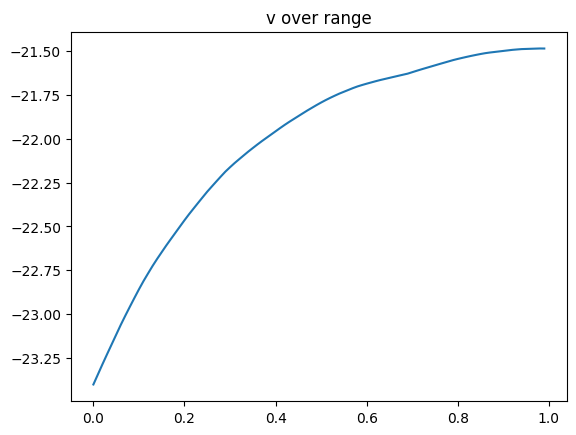

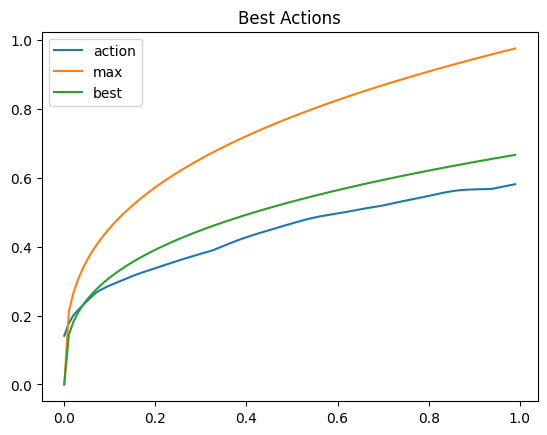

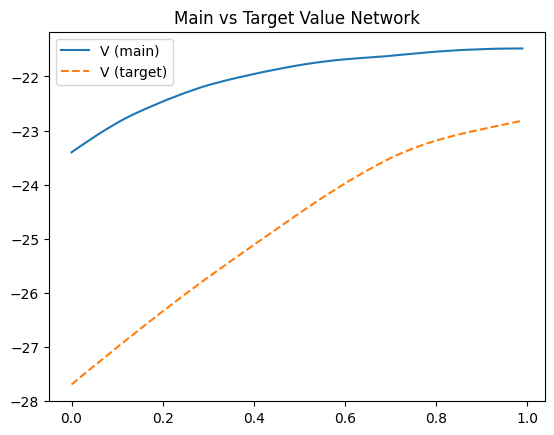

Step 110 utility -22.253983197566335
Step 120 utility -27.639819247217837
Step 130 utility -20.55398947655997
Step 140 utility -23.764605742700024


In [4]:
params = {'batch_size': 256,
          'hidden_sizes': [256, 256],
          'lr':1e-3,
          'tau':.001,
          'beta':.95,
          'coldstart_critic': True}

import train_rl
model = train_rl.run(**params)

In [9]:
from policy import diagnostics
from envs.economy import jesusfv
print(diagnostics.euler_error(model, jesusfv, 500, {'k': .1, 'z': 0}, clip=True, debug=True))

iter 0 eps -0.09306266097722911 k 0.1 z 0
iter 1 eps -0.1981754380983984 k 0.16664994552767093 z 0
iter 2 eps -0.2362546701616823 k 0.21601271517084342 z 0
iter 3 eps -0.2444634684474046 k 0.24318232270143236 z 0
iter 4 eps -0.24744799913729315 k 0.254882773969871 z 0
iter 5 eps -0.248685678843851 k 0.2596297697336094 z 0
iter 6 eps -0.24915851510482384 k 0.26153023791186225 z 0
iter 7 eps -0.24933924384686504 k 0.26228135417749576 z 0
iter 8 eps -0.24940936476141884 k 0.2625761601463088 z 0
iter 9 eps -0.24943659276083638 k 0.2626915851957248 z 0
iter 10 eps -0.2494474118734361 k 0.2627367200806102 z 0
iter 11 eps -0.24945175545448808 k 0.26275439586410776 z 0
iter 12 eps -0.24945305979570906 k 0.2627613071894279 z 0
iter 13 eps -0.24945388856682368 k 0.26276394504785794 z 0
iter 14 eps -0.24945421567107157 k 0.26276503051178846 z 0
iter 15 eps -0.24945398329648505 k 0.26276547689610974 z 0
iter 16 eps -0.2494541619626729 k 0.26276559362914353 z 0
iter 17 eps -0.24945381301708575 k 0.

Training actions coldstart
0 0.2777678966522217
[0] predicted mean: 0.9549, target mean: 0.4316, loss: 0.2778
25 0.0006303794798441231
[25] predicted mean: 0.4153, target mean: 0.4294, loss: 0.0006
50 5.9586331190075725e-05
[50] predicted mean: 0.4306, target mean: 0.4275, loss: 0.0001
75 1.1322326827212237e-05
[75] predicted mean: 0.4287, target mean: 0.4294, loss: 0.0000


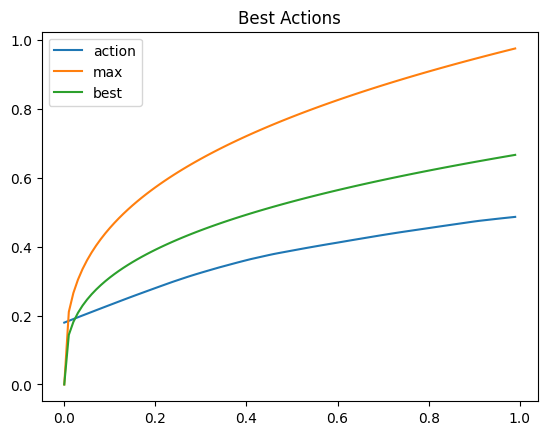

[Critic Pretraining Step 0] value loss = 0.740887
[Critic Pretraining Step 1] value loss = 0.591339
Before training, but after coldstart


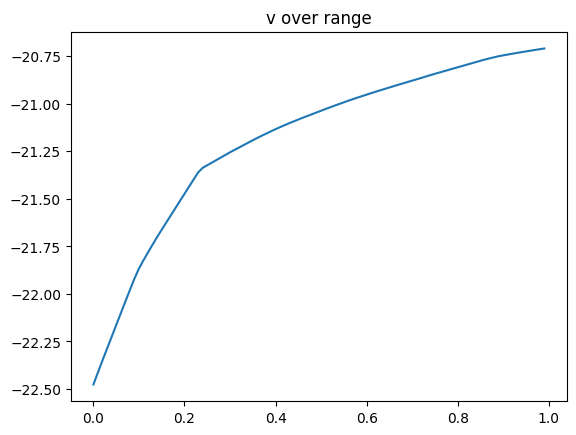

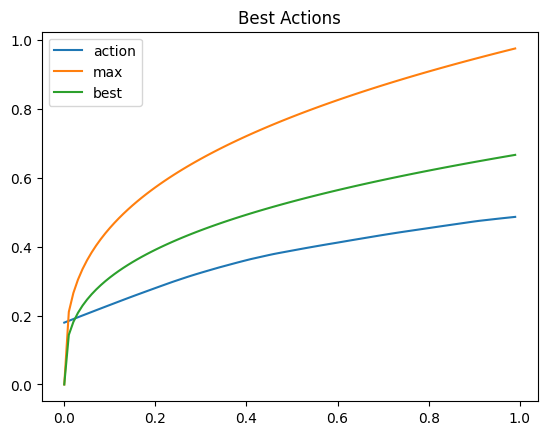

Step 0 utility -27.6901649738298
Episode 0 utility -27.6901649738298 convergence 7.667317447612731e-08 completed value error 0.00979828741401434 euler error 0.3689498157620788


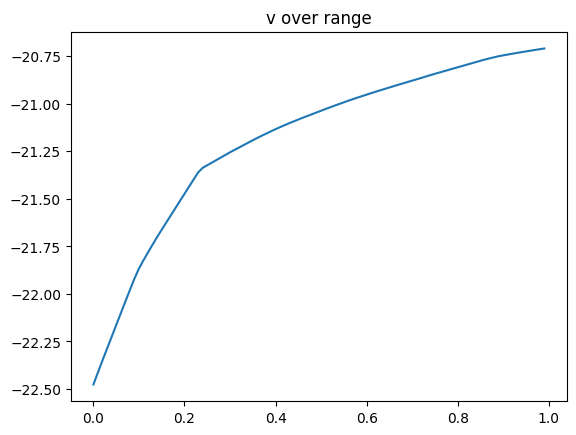

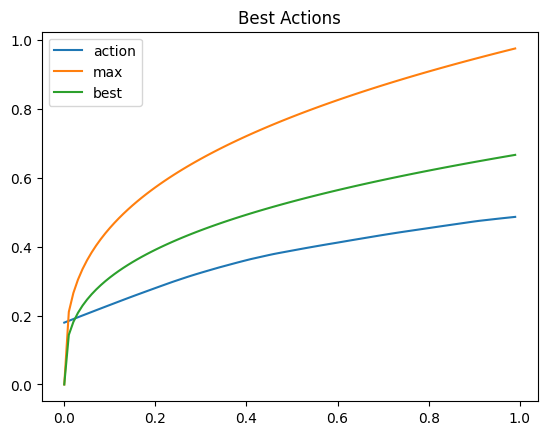

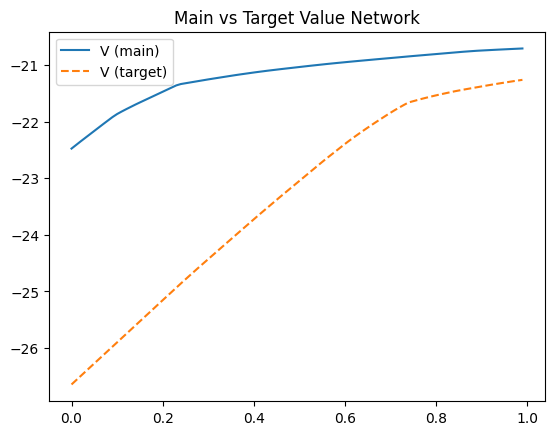

Step 10 utility -26.856967711587302
Step 20 utility -24.481695960420723
Step 30 utility -25.975839293288402
Step 40 utility -22.557478094585097
Step 50 utility -23.64892570025312
Episode 50 utility -23.64892570025312 convergence 0.01823241263628006 completed value error 0.019041895866394043 euler error 0.12266870881242078


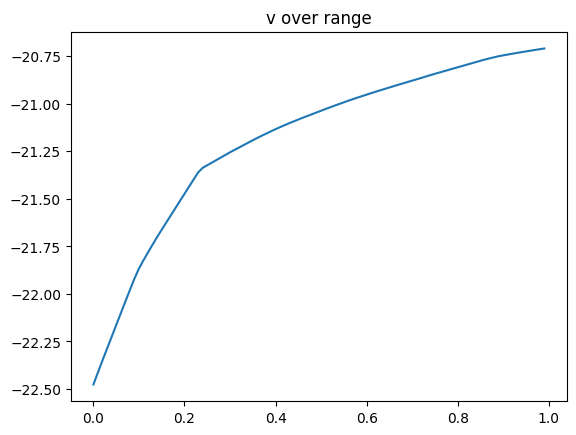

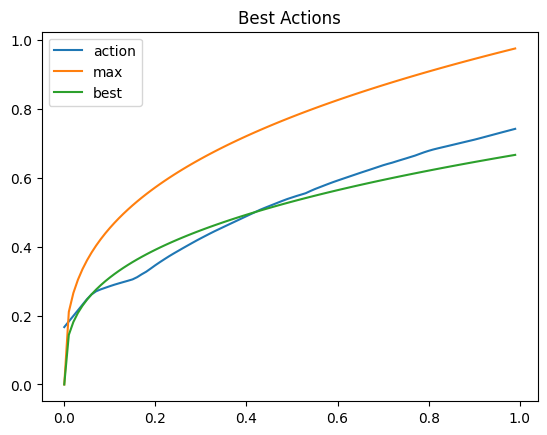

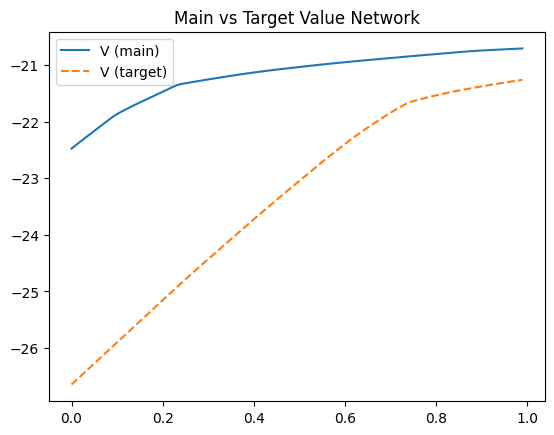

Step 60 utility -21.650219092359116
Step 70 utility -25.450211559740552
Step 80 utility -22.978345839726853
Step 90 utility -21.333099698183045
Step 100 utility -22.639088846322863
Episode 100 utility -22.639088846322863 convergence 0.010181285440921783 completed value error 0.006681344006210566 euler error 0.14418349630408656


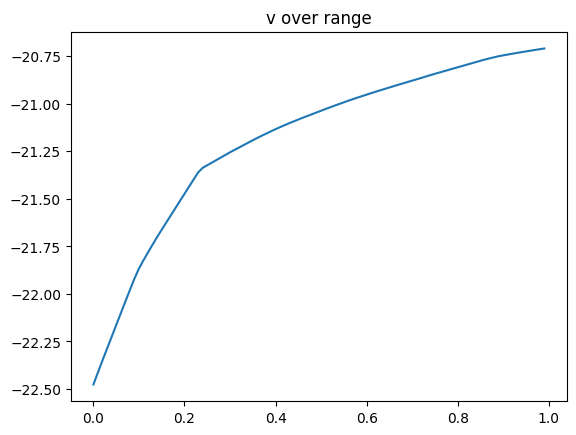

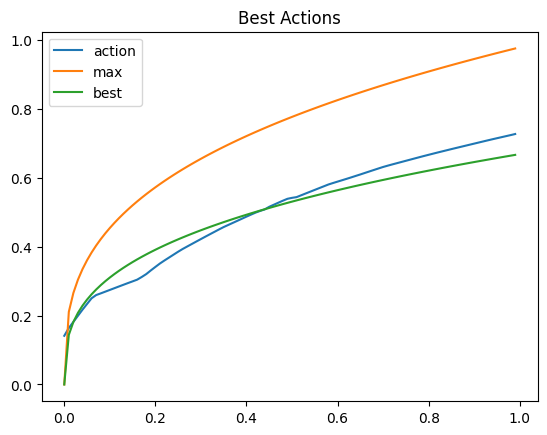

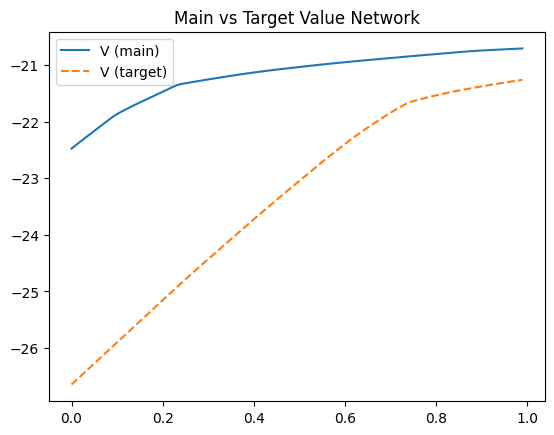

Step 110 utility -20.226593716470983
Step 120 utility -21.55428127308013
Step 130 utility -20.393515964510605
Step 140 utility -22.740578624546554


In [10]:
params = {'batch_size': 256,
          'hidden_sizes': [256, 256],
          'lr':1e-2,
          'tau':.001,
          'beta':.95,
          'coldstart_critic': True}

import train_rl
model = train_rl.run(**params)

In [11]:
print(diagnostics.euler_error(model, jesusfv, 500, {'k': .1, 'z': 0}, clip=True, debug=False))

0.13564776228833011
